# 1. Import all Modules

In [35]:
from datasets import load_dataset, load_metric
import accelerate
import torch
import gc
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_metric, DatasetDict
import rouge_score
import nltk
import absl
import os
import numpy as np
from torch.utils.data import DataLoader
from bert_score import score as bert_score
import nltk
import matplotlib.pyplot as plt

In [2]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# 2. Dataset

### 2.1 Import Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("neulab/conala", "curated")
dataset

DatasetDict({
    train: Dataset({
        features: ['question_id', 'intent', 'rewritten_intent', 'snippet'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['question_id', 'intent', 'rewritten_intent', 'snippet'],
        num_rows: 500
    })
})

### 2.2 Data preprocessing function

In [4]:
def preprocess_function(examples):
    # Ensure inputs (code snippets) and targets (explanations) are valid strings
    valid_inputs = []
    valid_targets = []
    for code, intent in zip(examples["snippet"], examples["rewritten_intent"]):
        if isinstance(code, str) and isinstance(intent, str):
            valid_inputs.append(f"explain: {code}")
            valid_targets.append(intent)

    # Ensure valid_inputs and valid_targets are not empty to prevent errors
    if not valid_inputs or not valid_targets:
        return {"input_ids": [], "attention_mask": [], "labels": []}

    # Tokenize inputs and targets
    tokenized_inputs = tokenizer(
        valid_inputs,
        max_length=32,
        truncation=True,
        padding="max_length"
    )
    tokenized_targets = tokenizer(
        valid_targets,
        max_length=64,
        truncation=True,
        padding="max_length"
    )

    # Add the tokenized targets to the input dictionary as "labels"
    tokenized_inputs["labels"] = tokenized_targets["input_ids"]

    return tokenized_inputs

In [5]:
# Check for invalid rows
invalid_rows = dataset["train"].filter(
    lambda example: not isinstance(example["snippet"], str) or not isinstance(example["rewritten_intent"], str)
)
print(f"Number of invalid rows: {len(invalid_rows)}")

Number of invalid rows: 79


In [6]:
# Remove invalid rows
dataset = dataset.filter(
    lambda example: isinstance(example["snippet"], str) and isinstance(example["rewritten_intent"], str)
)
dataset

DatasetDict({
    train: Dataset({
        features: ['question_id', 'intent', 'rewritten_intent', 'snippet'],
        num_rows: 2300
    })
    test: Dataset({
        features: ['question_id', 'intent', 'rewritten_intent', 'snippet'],
        num_rows: 477
    })
})

### Clear Cache

In [10]:
# Clear cache periodically
torch.cuda.empty_cache()

# 3. Model Training (with Memory Management Technique)

In [11]:
def compute_metrics(eval_pred):
    # Unpack predictions and labels
    predictions, labels = eval_pred

    # Convert to numpy arrays if needed
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    # Clear memory
    torch.cuda.empty_cache()

    # Decode predictions and labels
    decoded_preds = []
    decoded_labels = []
    chunk_size = 16  # Adjust as needed
    for i in range(0, len(predictions), chunk_size):
        chunk_preds = predictions[i:i + chunk_size]
        chunk_labels = labels[i:i + chunk_size]

        # Ensure proper format for decoding
        if isinstance(chunk_preds[0], list):
            chunk_preds = [int(token) for sublist in chunk_preds for token in sublist]
        if isinstance(chunk_labels[0], list):
            chunk_labels = [int(token) for sublist in chunk_labels for token in sublist]

        decoded_preds.extend(tokenizer.batch_decode(chunk_preds, skip_special_tokens=True))
        decoded_labels.extend(tokenizer.batch_decode(chunk_labels, skip_special_tokens=True))

    # Print for debugging
    print(f"Decoded predictions: {decoded_preds}")
    print(f"Decoded labels: {decoded_labels}")

    # Compute and return Rouge scores
    result = metric.compute(
        predictions=[pred.strip() for pred in decoded_preds],
        references=[label.strip() for label in decoded_labels],
        use_stemmer=True
    )
    print(f"Rouge scores: {result}")

    return {key: value.mid.fmeasure for key, value in result.items()}



# Define Trainer with additional memory management
class MemoryEfficientTrainer(Trainer):
    def training_step(self, model, inputs):
        # Run garbage collection and clear GPU memory before training step
        torch.cuda.empty_cache()
        gc.collect()

        return super().training_step(model, inputs)

    def evaluation_step(self, model, inputs, prediction_loss_only=False):
        # Run garbage collection and clear GPU memory before evaluation step
        torch.cuda.empty_cache()
        gc.collect()

        return super().evaluation_step(model, inputs, prediction_loss_only=prediction_loss_only)

def train_with_retry(trainer, max_retries=3, last_checkpoint=None):
    retries = 0
    while retries < max_retries:
        try:
            trainer.train(resume_from_checkpoint=last_checkpoint)
            break  # Exit loop if training succeeds
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"Out of memory error detected. Clearing cache and retrying... (Attempt {retries + 1}/{max_retries})")
                torch.cuda.empty_cache()
                gc.collect()
                retries += 1
                last_checkpoint = trainer.state.best_model_checkpoint  # Update to the latest checkpoint
            else:
                raise  # Raise other errors
    else:
        print("Training failed after maximum retries.")


def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [12]:
# Load the T5 tokenizer and model
model_name = "t5-small"  # Switch to "t5-tiny" if needed
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Preprocess the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=1,  # Reduce batch size
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,  # Increase accumulation steps
    num_train_epochs=1
    
    0,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    report_to="none",
    fp16=True,  # Mixed precision to reduce memory usage
    dataloader_pin_memory=True,  # Enable pinned memory
    dataloader_num_workers=4,  # Adjust data loader workers
)

# Metric for evaluation
metric = load_metric("rouge")

# Initialize the MemoryEfficientTrainer
trainer = MemoryEfficientTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)


# Train the model
try:
    for epoch in range(training_args.num_train_epochs):
        print(f"Starting epoch {epoch + 1}/{training_args.num_train_epochs}...")
        clear_memory()
        
        trainer.train()
        
        # Clear GPU memory after training
        clear_memory()

        # Perform evaluation at the end of each epoch
        trainer.evaluate()

        # Clear GPU memory after evaluation
        clear_memory()

except RuntimeError as e:
    if "out of memory" in str(e):
        print("Out of memory error detected. Clearing cache...")
        torch.cuda.empty_cache()
        gc.collect()
    else:
        raise

D:\Projects\AI Code Generator\AICG.env\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Starting epoch 1/10...


Epoch,Training Loss,Validation Loss
0,7.265500,1.658271
1,2.914500,1.369148
2,1.602100,1.244390
4,1.280800,1.067841
5,1.230700,1.013551
6,1.148200,0.969668
8,1.110100,0.932253
9,1.104600,0.927910


Starting epoch 2/10...


Epoch,Training Loss,Validation Loss
0,1.074600,0.879400
1,1.049600,0.849605
2,0.991900,0.831254
4,0.958600,0.809541
5,0.948600,0.802673
6,0.925400,0.797707
8,0.918700,0.792154
9,0.922600,0.791580


Starting epoch 3/10...


Epoch,Training Loss,Validation Loss
0,0.914000,0.781193
1,0.908900,0.772475
2,0.890900,0.765170
4,0.880500,0.755628
5,0.873100,0.752398
6,0.856200,0.749403
8,0.851500,0.746963
9,0.862600,0.746615


Starting epoch 4/10...


Epoch,Training Loss,Validation Loss
0,0.854500,0.740787
1,0.848600,0.735972
2,0.835700,0.731770
4,0.832800,0.725439
5,0.827700,0.723200
6,0.814300,0.721395
8,0.809800,0.719749
9,0.818800,0.719599


Starting epoch 5/10...


Epoch,Training Loss,Validation Loss
0,0.813100,0.715722
1,0.809700,0.712445
2,0.798700,0.709482
4,0.801600,0.704954
5,0.797900,0.703470
6,0.784900,0.702454
8,0.778700,0.700856
9,0.789600,0.700700


Starting epoch 6/10...


Epoch,Training Loss,Validation Loss
0,0.780900,0.697803
1,0.782400,0.694751
2,0.774400,0.692411
4,0.774500,0.688812
5,0.772700,0.687727
6,0.758300,0.686686
8,0.754100,0.685621
9,0.765700,0.685518


Starting epoch 7/10...


Epoch,Training Loss,Validation Loss
0,0.758400,0.683044
1,0.757600,0.680706
2,0.749900,0.678959
4,0.752800,0.676111
5,0.746100,0.675141
6,0.737400,0.674533
8,0.735600,0.673598
9,0.741100,0.673531


Starting epoch 8/10...


Epoch,Training Loss,Validation Loss
0,0.734600,0.671890
1,0.736500,0.669758
2,0.729300,0.668270
4,0.732300,0.665580
5,0.728700,0.664639
6,0.717000,0.663990
8,0.717200,0.663387
9,0.724500,0.663300


Starting epoch 9/10...


Epoch,Training Loss,Validation Loss
0,0.716700,0.661553
1,0.718500,0.659809
2,0.714200,0.658813
4,0.715500,0.656756
5,0.710500,0.656145
6,0.701000,0.655755
8,0.699300,0.655040
9,0.706500,0.655024


Starting epoch 10/10...


Epoch,Training Loss,Validation Loss
0,0.699000,0.653441
1,0.702300,0.652414
2,0.693700,0.651137
4,0.697800,0.649424
5,0.696500,0.649015
6,0.683400,0.648444
8,0.683700,0.648123
9,0.688000,0.648081


# 4. Prediction

### 4.1 Set-up for prediction

In [29]:
# Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def predict(snippet):
    """
    Generates a prediction (explanation) for a given code snippet.

    Args:
        snippet (str): The input code snippet.

    Returns:
        str: The generated explanation.
    """
    # Preprocess the input snippet
    input_text = f"explain: {snippet}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=32, truncation=True, padding="max_length")

    # Move input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate prediction
    outputs = model.generate(
        inputs["input_ids"],
        max_length=64,
        num_beams=4,  # Beam search for better results
        early_stopping=True
    )

    # Decode the prediction
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return prediction

In [34]:
# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example code snippet
index = np.random.randint(len(dataset["test"]["snippet"]))
code_snippet = dataset["test"]["snippet"][index]

# Tokenize the input
inputs = tokenizer(
    f"explain: {code_snippet}",
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=32
)

# Move inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Generate prediction
outputs = model.generate(**inputs)
explanation = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the result
print(f"Code Snippet: {code_snippet}")
print(f"Explanation: {explanation}")

Code Snippet: ut.sort(key=lambda x: x.count, reverse=True)
Explanation: sort a list ut by a tuple count


### 4.2 To check raw Input tensor

In [19]:
snippet = "def add(a, b): return a + b"
input_text = f"explain: {snippet}"
inputs = tokenizer(input_text, return_tensors="pt", max_length=32, truncation=True, padding="max_length")

# Move input tensors to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}
# Generate prediction
outputs = model.generate(
    inputs["input_ids"],
    max_length=32,
    num_beams=4,
    early_stopping=True
)

# Print raw outputs (token IDs)
print("Raw Output IDs:", outputs)

# Decode the prediction
prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Decoded Prediction:", prediction)

Raw Output IDs: tensor([[   0,   20,   89,  617,    3,    9, 1768,    3,  115,   12,    3,    9,
          570,    3,    2,    9,    2,    1]], device='cuda:0')
Decoded Prediction: def add a + b to a list a


# 5. Evaluation Metrics

In [27]:
nltk.download('punkt')
nltk.download('punkt_tab')

# Load metrics
rouge = load_metric("rouge")
sacrebleu = load_metric("sacrebleu")
meteor = load_metric("meteor")
exact_match = load_metric("exact_match")

# Function to compute evaluation metrics
def evaluate_model(model, tokenizer, eval_dataset, batch_size=1, max_length=32, device="cuda"):
    """
    Evaluates the model on the given evaluation dataset using multiple metrics.

    Args:
        model: The fine-tuned T5 model.
        tokenizer: The tokenizer used for the model.
        eval_dataset: The evaluation dataset (must contain 'snippet' and 'rewritten_intent').
        batch_size: Batch size for evaluation.
        max_length: Max length for generated text.
        device: Device to run the evaluation on ('cuda' or 'cpu').

    Returns:
        dict: Dictionary containing various metrics.
    """
    model.eval()
    model.to(device)

    # DataLoader for batching
    dataloader = DataLoader(eval_dataset, batch_size=batch_size)

    all_predictions = []
    all_labels = []

    # Loop through the evaluation dataset
    for batch in dataloader:
        # Extract input texts and reference labels
        inputs = [f"explain: {text}" for text in batch["snippet"]]
        labels = batch["rewritten_intent"]

        # Tokenize inputs and move to device
        tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        tokenized_inputs = {key: value.to(device) for key, value in tokenized_inputs.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                tokenized_inputs["input_ids"],
                max_length=max_length,
                num_beams=4,
                early_stopping=True
            )

        # Decode predictions and references
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Compute ROUGE scores
    rouge_result = rouge.compute(predictions=all_predictions, references=all_labels, use_stemmer=True)
    rouge_scores = {key: value.mid.fmeasure for key, value in rouge_result.items()}

    # Compute SacreBLEU scores
    sacrebleu_score = sacrebleu.compute(predictions=all_predictions, references=[[ref] for ref in all_labels])

    # Compute METEOR scores
    meteor_score = meteor.compute(predictions=all_predictions, references=all_labels)

    # Compute Exact Match scores
    exact_match_score = exact_match.compute(predictions=all_predictions, references=all_labels)

    # Compute BERTScore
    bertscore_precision, bertscore_recall, bertscore_f1 = bert_score(
        cands=all_predictions, refs=all_labels, lang="en", device=device
    )

    # Aggregate results
    metrics = {
        "rouge": rouge_scores,
        "sacrebleu": sacrebleu_score["score"],
        "meteor": meteor_score["meteor"],
        "exact_match": exact_match_score["exact_match"],
        "bertscore_precision": bertscore_precision.mean().item(),
        "bertscore_recall": bertscore_recall.mean().item(),
        "bertscore_f1": bertscore_f1.mean().item()
    }

    return metrics


# Example usage
tokenized_datasets = dataset.map(preprocess_function, batched=True)

eval_scores = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=tokenized_datasets["test"],
    batch_size=8,  # Adjust batch size based on your GPU memory
    max_length=64,  # Match the max length used during training
    device="cuda"  # Use 'cuda' if you have a GPU, otherwise 'cpu'
)

# Print evaluation metrics
print("Evaluation Metrics:")
for metric, value in eval_scores.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
D:\Projects\AI Code Generator\AICG.env\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
D:\Projects\AI Code Generator\AICG.env\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must 

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics:
rouge: {'rouge1': 0.38326906329123506, 'rouge2': 0.16309903385023367, 'rougeL': 0.34328986872763456, 'rougeLsum': 0.3436455090073123}
sacrebleu: 10.4388
meteor: 0.1947
exact_match: 0.0000
bertscore_precision: 0.8830
bertscore_recall: 0.8602
bertscore_f1: 0.8712


# 7. Save and Load (Model, Tokenizer and History)

#### 7.1 Save Model, Tokenizer and History

In [13]:
# Define the save path
save_path = "../Models/Model_V3/"  # Change this to your desired directory path

# Make sure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# Save the training history (logs and metrics)
# Convert training arguments into a serializable format
training_args_dict = {key: str(value) if not isinstance(value, (str, int, float, bool, list, dict)) else value
                      for key, value in vars(training_args).items()}

training_history = {
    "train_loss_history": trainer.state.log_history,
    "best_model_checkpoint": trainer.state.best_model_checkpoint,
    "total_steps": trainer.state.global_step,
    "training_args": training_args_dict  # Serialized training arguments
}

with open(os.path.join(save_path, "training_history.json"), "w") as f:
    json.dump(training_history, f, indent=4)

print(f"Model and training history saved to {save_path}")

Model and training history saved to ../Models/Model_V3/


### 7.2 Load Model, Tokenizer and History

In [44]:
# Load the model and tokenizer from the saved path
model = T5ForConditionalGeneration.from_pretrained("../Models/Model_V3/")
tokenizer = T5Tokenizer.from_pretrained("../Models/Model_V3/")

# Optionally, load the training history
with open("../Models/Model_V3/training_history.json", "r") as f:
    training_history = json.load(f)

print("Training history:", training_history)

Training history: {'train_loss_history': [{'loss': 0.699, 'grad_norm': 0.6693894863128662, 'learning_rate': 9.300699300699301e-06, 'epoch': 0.6956521739130435, 'step': 100}, {'eval_loss': 0.653440535068512, 'eval_runtime': 9.3499, 'eval_samples_per_second': 51.017, 'eval_steps_per_second': 51.017, 'epoch': 0.9947826086956522, 'step': 143}, {'loss': 0.7023, 'grad_norm': 0.7555273771286011, 'learning_rate': 8.601398601398602e-06, 'epoch': 1.391304347826087, 'step': 200}, {'eval_loss': 0.6524140238761902, 'eval_runtime': 9.5612, 'eval_samples_per_second': 49.889, 'eval_steps_per_second': 49.889, 'epoch': 1.9965217391304346, 'step': 287}, {'loss': 0.7099, 'grad_norm': 0.7096579074859619, 'learning_rate': 7.902097902097902e-06, 'epoch': 2.0869565217391304, 'step': 300}, {'loss': 0.6937, 'grad_norm': 0.6902344822883606, 'learning_rate': 7.202797202797203e-06, 'epoch': 2.782608695652174, 'step': 400}, {'eval_loss': 0.6511369943618774, 'eval_runtime': 8.7122, 'eval_samples_per_second': 54.751,

# 8. History Plot

In [40]:
# Extract training and validation metrics from the history dictionary
def extract_metrics(training_history):
    train_loss = []
    val_loss = []
    epochs_train = []
    epochs_val = []

    # Extract the list of records from `training_history`
    records = training_history.get('train_loss_history', [])

    for record in records:
        if isinstance(record, dict):  # Ensure each entry is a dictionary
            if "loss" in record:  # Training loss
                train_loss.append(record["loss"])
                epochs_train.append(record["epoch"])
            if "eval_loss" in record:  # Validation loss
                val_loss.append(record["eval_loss"])
                epochs_val.append(record["epoch"])

    return train_loss, val_loss, epochs_train, epochs_val

# Plotting function
def plot_metrics(train_loss, val_loss, epochs_train, epochs_val):
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(epochs_train, train_loss, label='Training Loss', marker='o', color='blue')
    # Plot validation loss
    plt.plot(epochs_val, val_loss, label='Validation Loss', marker='o', color='red')

    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

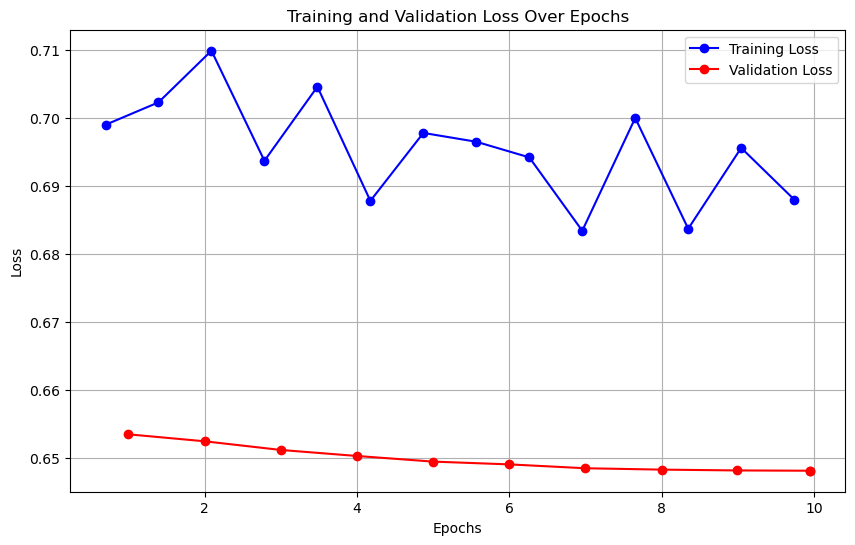

In [47]:
# Use the updated training history
train_loss, val_loss, epochs_train, epochs_val = extract_metrics(training_history)

# Plot
plot_metrics(train_loss, val_loss, epochs_train, epochs_val)